<a href="https://colab.research.google.com/github/VishnuRathore98/Machine_Learning/blob/master/Dwell_Time_Analysis_with_Computer_Vision_Real_Time_Stream_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q  supervision opencv-python ultralytics inference

  Preparing metadata (setup.py) ... done


In [21]:
import numpy as np
import supervision as sv
import cv2
import ultralytics
from inference import get_model
from datetime import datetime
from google.colab.patches import cv2_imshow
from general import load_zones_config


In [3]:
class FPSBasedTimer:
  def __init__(self, fps):
    self.fps = fps
    self.frame_id = 0
    self.tracker_id2frame_id = {}

  def tick(self, detections):
    self.frame_id += 1
    times = []

    for tracker_id in detections.tracker_id:
      self.tracker_id2frame_id.setdefault(tracker_id, self.frame_id)

      start_frame_id = self.tracker_id2frame_id[tracker_id]
      time_duration = (self.frame_id - start_frame_id)/self.fps
      times.append(time_duration)

    return np.array(times)

In [4]:
class ClockBasedTimer:
  def __init__(self):
    self.tracker_id2start_time = {}

  def tick(self, detections):
    current_time = datetime.now()
    times = []

    for tracker_id in detections.tracker_id:
      self.tracker_id2start_time.setdefault(tracker_id, current_time)

      start_time =  self.tracker_id2start_time[tracker_id]
      time_duration = (current_time - start_time).total_seconds()
      times.append(time_duration)

    return np.array(times)

In [5]:
model = get_model(model_id="yolov8x-640")
# model.device_id = 0
tracker = sv.ByteTrack()

In [38]:

COLORS = sv.ColorPalette.from_hex(["#E6194B", "#3CB44B", "#FFE119", "#3C76D1"])
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Time analysis/Checkout.mp4"
RESULT_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Time analysis/checkout_result.mp4"
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

BOUNDING_BOX_ANNOTATOR = sv.BoxAnnotator()
LABEL_ANNOTATOR = sv.LabelAnnotator()
i=0

SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.


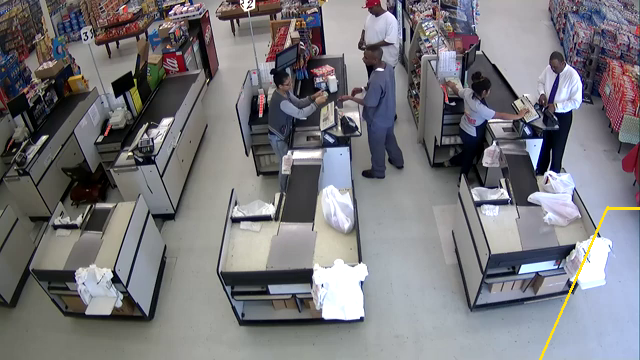

frame  1


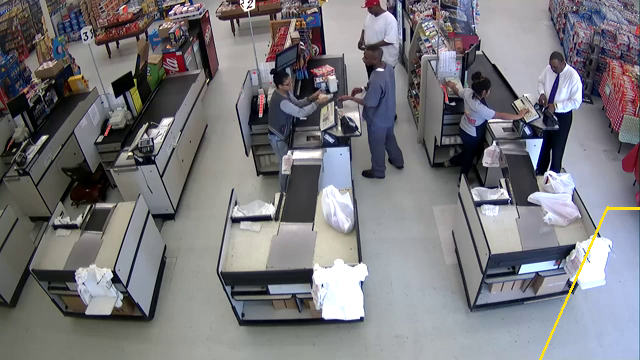

frame  2


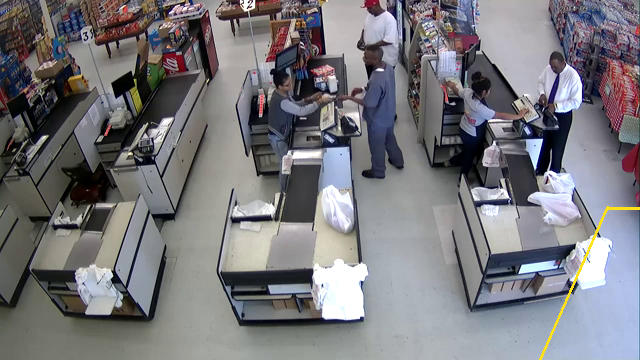

frame  3


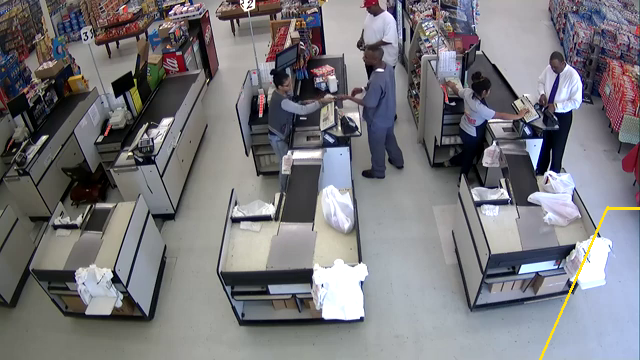

frame  4


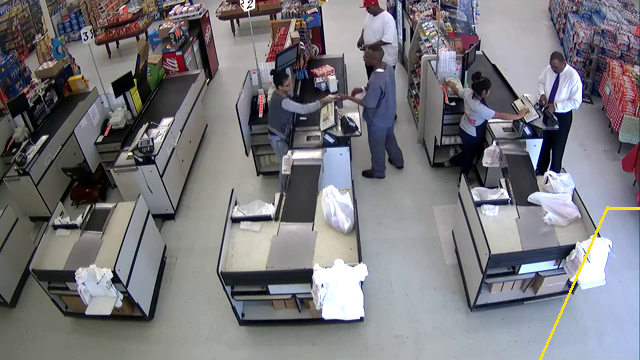

frame  5


KeyboardInterrupt: 

In [39]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = next(frame_generator)
resolution_wh = frame.shape[1], frame.shape[0]
polygons = load_zones_config(file_path="/content/drive/MyDrive/Colab Notebooks/Time analysis/config2.json")

zones = [sv.PolygonZone(polygon=polygon, frame_resolution_wh=resolution_wh, triggering_anchors=(sv.Position.CENTER,)) for poygon in polygons]

# with sv.VideoSink(target_path=RESULT_VIDEO_PATH, video_info=video_info) as sink:
for frame in frame_generator:
  i+=1

  results = model.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)[0]

  detections = sv.Detections.from_inference(results)
  detections = detections[detections.class_id == 0]
  detections = tracker.update_with_detections(detections=detections)


  annotated_frame = frame.copy()
  for idx, zone in enumerate(zones):
    annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=zone.polygon, color=COLORS.by_idx(idx), thickness=2)
    detections_in_zone = detections[zone.trigger(detections)]
    annotated_frame = BOUNDING_BOX_ANNOTATOR.annotate(scene = annotated_frame, detections = detections_in_zone)

    labels = [f"{tracker_id}" for tracker_id in detections_in_zone.tracker_id]

    annotated_frame = LABEL_ANNOTATOR.annotate(scene = annotated_frame, detections = detections_in_zone, labels = labels)
  cv2_imshow(annotated_frame)
  # annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
  # sink.write_frame(annotated_frame)
  print("frame ",i)